## Một thủ thuật Toán lợi hại để hiểu những điều tưởng không thể

Khi vận dụng phương pháp sai khác của biến thiên, chúng ta sử dụng dữ liệu về một số khách hàng từ 2 thành phố khác nhau: Porto Alegre và Florianópolis. Dữ liệu trải dài qua 2 khoảng thời gian: trước và sau khi thực hiện chiến dịch marketing tại Porto Alegre nhằm tăng lượng tiền gửi của khách hàng. Để ước lượng tác động can thiệp, chúng ta đã chạy một mô hình hồi quy để cho ra mô hình sai khác của biến thiên và sai số chuẩn của mô hình.

Trong trường hợp đó, chúng ta có rất nhiều mẫu, bởi vì dữ liệu khá chi tiết. Nhưng điều gì xảy ra nếu ta chỉ có bộ dữ liệu được tổng hợp ở cấp thành phố? Ví dụ, giả sử tất cả những gì chúng ta có là lượng tiền gửi trung bình ở cả hai thành phố trước và sau khi can thiệp.

|Thành Phố|Trước Can Thiệp|Sau Can Thiệp|
|--|--|--|
|FL|171.64|206.16|
|POA|46.01|87.06|

Chúng ta vẫn có thể ước lượng được Diff-in-Diff estimator

$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53
$


Tuy nhiên, lưu ý rằng kích thước mẫu tại đây có giá trị là 4, cũng chính là số lượng tham số trong mô hình sai khác của biến thiên. Trong trường hợp này, sai số chuẩn không được xác định một cách chính xác, vậy chúng ta nên làm gì? Một vấn đề khác là Florianopolis có thể sẽ không giống với Porto Alegre theo cách chúng ta muốn. Ví dụ, Florianopolis được biết đến với những bãi biển đẹp cũng như sự mến khách của dân địa phương trong khi Porto Alegre lại nổi tiếng với món thịt nướng và những gã cao bồi đặc trưng. Vấn đề là bạn không thể biết chắc liệu mình có đang sử dụng một nhóm đối chứng phù hợp hay không.

Để giải quyết vấn đề này, chúng ta sẽ sử dụng một phương pháp được biến đến là [**"sáng kiến quan trọng nhất đối với những bài báo đánh giá chính sách trong những năn gần đây"**](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.3), Đối Chứng Tổng Hợp. Nó dựa trên một ý tưởng tuy đơn giản nhưng rất mạnh mẽ. Chúng ta không cần phải tìm bất kỳ nhóm đối chứng nào giống với nhóm được can thiệp. Thay vào đó, chúng ta có thể tự tạo ra nó bằng cách kết hợp nhiều nhóm đối chứng, tạo ra đối chứng tổng hợp một cách hiệu quả. Đối chứng tổng hợp hiệu quả và trực quan đến mức được xuất bản trên cả một bài báo đại chúng, mà không chỉ dành riêng cho tạp chí khoa học, đó là nhật báo [Washington Post](https://www.washingtonpost.com/news/wonk/wp/2015/10/30/how-to-measure-things-in-a-world-of-competing-claims/).

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

Để xem cách nó hoạt động, ta sẽ ước lượng tác động của việc đánh thuế thuốc lá đối với mức tiêu thụ thuốc lá. Đây là một câu hỏi đã gây tranh cãi suốt một thời gian dài trong kinh tế học. Một bên lập luận rằng việc áp thuế sẽ làm gia tăng giá thuốc lá, điều này sẽ làm giảm nhu cầu mua thuốc lá. Bên còn lại cho rằng vì thuốc lá gây nghiện nên việc thay đổi giá cả sẽ không làm thay đổi nhiều đến nhu cầu của họ. Theo thuật ngữ kinh tế học, chúng ta có thể nói rằng nhu cầu thuốc lá không co giãn theo giá, và việc tăng thuế chỉ là một cách để tăng ngân sách nhà nước với chi phí của chính người hút thuốc. Để làm rõ vấn đề này, chúng ta sẽ xem xét một số dữ liệu có liên quan tại Mỹ.

Vào năm 1988, California đã thông qua Đạo luật nổi tiếng về Thuế Thuốc lá và Bảo vệ Sức khỏe, gọi là [Dự luật 99](https://en.wikipedia.org/wiki/1988_California_Proposition_99). "Tác động chính của nó là áp thuế tiêu thụ đặc biệt 25% trên mỗi bao thuốc lá bán ra tại bang California, mức thuế tương đương cũng được áp dụng tương tự đối với các sản phẩm khác của thuốc lá thương mại, chẳng hạn như xì gà và thuốc lá nhai. Các hạn chế bổ sung được đặt ra đối với ngành bán lẻ thuốc lá bao gồm lệnh cấm đặt máy bán thuốc lá tự động tại nơi công cộng, và lệnh cấm bán lẻ từng điếu thuốc. Số tiền thu được từ đạo luật sẽ dành cho các chương trình về môi trường và chăm sóc sức khỏe, cũng như việc chống quảng cáo thuốc lá."

Để đánh giá tác động của nó, chúng ta có thể thu thập dữ liệu về doanh số thuốc lá từ nhiều tiểu bang trong một vài năm. Trong trường hợp này, chúng ta lấy dữ liệu từ năm 1970 đến năm 2000 gồm 39 tiểu bang. Những bang khác có chương trình kiểm soát Thuốc lá tương tự đã bị loại khỏi bảng phân tích. Đây là dữ liệu của chúng ta.

In [4]:
cigar = (pd.read_csv("data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


Chúng ta có `state` là chỉ số tiểu bang, trong đó California là số 3. Biến giải thích là `retprice`, giá bán lẻ thuốc lá và `cigsale`, doanh số bán bình quân đầu người của thuốc lá (bao). Biến kết quả cần quan tâm là `cigsale`. Cuối cùng, chúng ta có các biến nhị phân để nhận biết dữ liệu từ bang California và giai đoạn sau can thiệp. Nếu chúng ta lập biểu đồ doanh số thuốc lá cho California và các tiểu bang khác theo thời gian, thì đây là những gì chúng ta nhận được.

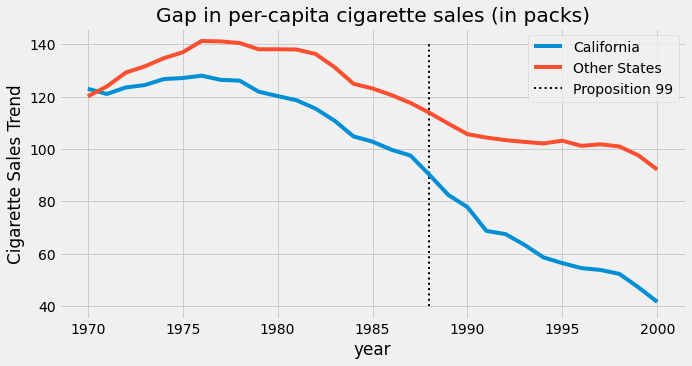

In [5]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

Trong khoảng thời gian được biểu thị, người dân tại bang California dường như mua ít thuốc lá hơn mức trung bình toàn quốc. Ngoài ra, việc tiêu thụ thuốc lá có vẻ giảm dần sau những năm 80. Có vẻ như sau Dự luật 99, xu hướng giảm càng rõ rệt tại California khi so với các tiểu bang khác, nhưng ta không thể dám chắc điều đó. Dù sao nó cũng chỉ là một phỏng đoán khi ta phân tích biểu đồ.

Để trả lời câu hỏi liệu Dự luật 99 có tác động đến việc tiêu thụ thuốc lá hay không, chúng ta sẽ sử dụng giai đoạn trước can thiệp để thiết lập đối chứng tổng hợp. Chúng ta sẽ kết hợp các tiểu bang khác để **thiết lập một tiểu bang giả có xu hướng giống với bang California**. Sau đó, chúng ta sẽ xem phương pháp đối chứng tổng hợp này hoạt động như thế nào sau can thiệp.

## Chúng ta có Thời gian

Để thực hiện vấn đề này theo hướng chính quy một chút, giả sử rằng ta có J+1 đối tượng. Không mất tính tổng quát, giả sử rằng đối tượng 1 bị tác động bởi can thiệp. Các đối tượng \\(j=2,...,J+1\\) là một tập hợp các đối tượng đối chứng, sau đây được gọi là "tổ hợp đối chứng". Bên cạnh đó, giả sử dữ liệu của chúng ta trải đều qua các thời điểm T, với \\(T_0\\) là thời điểm trước khi can thiệp. Với mỗi đối tượngcá thể j và thời điểm t, chúng ta quan sát kết quả \\(Y_{jt}\\). Đối với mỗi đơn vị j và thời điểm t, cho \\(Y^N_{jt}\\) là kết quả tiềm năng khi không có can thiệp và \\(Y^I_{jt}\\), là kết quả tiềm năng khi có can thiệp. Sau đó, tác động của đối tượng được can thiệp \\(j=1\\) tại thời điểm t, cho \\(t>T_0\\) được xác định như sau

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

Bởi vì đối tượng \\(j = 1\\) được can thiệp, \\(Y^I_{jt}\\) là kết quả thực trong khi \\(Y^N_{jt}\\) thì không. Vậy nên thử thách bây giờ là làm thế nào để ước lượng \\(Y^N_{jt}\\). Lưu ý cách tác động can thiệp được xác định cho từng thời kỳ, nghĩa là nó có thể thay đổi theo thời gian, không nhất thiết phải là tức thời. Nó có thể tích tụ hoặc tiêu tan. Nói một cách dễ hiểu, vấn đề ước lượng tác động can thiệp chính là ước lượng điều gì sẽ xảy ra đối với kết quả của đối tượng \\(j=1\\) nếu nó không được can thiệp.

![img](data/img/synth-control/synth_img.png)

Để ước lượng \(Y^N_{jt}\\), nên nhớ rằng sự kết hợp của các đối tượng trong tổ hợp đối chứng có thể tương đồng hơn với các đặc điểm của đối tượng được can thiệp so với bất kỳ đối tượng đối chứng đơn lẻ nào. Do đó, đối chứng tổng hợp được định nghĩa là bình quân gia quyền của các đối tượng trong nhóm đối chứng. Với trọng số \\(\pmb{W}=(w_2, ..., w_{J+1})\\), ước lượng của đối chứng tổng hợp \\(Y^N_{jt}\\) có giá trị

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

Nếu bạn thấy đau đầu với những phép tính trên thì bạn không hề đơn độc đâu. Đừng lo lắng, chúng ta có rất nhiều ví dụ để làm cho nó trực quan hơn. Hãy thử một lần nghĩ về đối chứng tổng hợp như một cách đảo ngược của phép hồi quy. Như chúng ta đã biết, hồi quy tuyến tính cũng là một cách để dự đoán dựa vào bình quân gia quyền của các biến. Hãy nghĩ về những hồi quy đó giống như hồi quy trong ví dụ của phương pháp sai khác của biến thiên, trong đó mỗi biến là một biến giả cho một khoảng thời gian. Trong trường hợp này, hồi quy có thể được biểu diễn bởi tích của các ma trận sau

![img](data/img/synth-control/regr_time.png)

Trong trường hợp đối chứng tổng hợp, chúng ta không có nhiều đối tượng, nhưng chúng ta có rất nhiều khoảng thời gian. Vì vậy, những gì ta làm là lật ngược ma trận của dữ liệu đầu vào. Sau đó, các đối tượng trở thành các "biến" và chúng ta biểu diễn kết quả theo bình quân gia quyền của các đối tượng, giống với tích của các ma trận sau.

![img](data/img/synth-control/regr_space.png)

Nếu ta có nhiều hơn một đặc điểm trong một khoảng thời gian, chúng ta có thể gom chúng lại. Điều quan trọng của việc này là để phép hồi quy "dự đoán" đối tượng can thiệp 1 bằng các đối tượng khác. Bằng cách này, chúng ta có thể chọn trọng số theo một cách tối ưu nào đó để đạt được tỷ lệ mong muốn. Chúng ta thậm chí có thể chia tỷ lệ khác nhau cho từng đặc điểm để biểu thị tầm quan trọng của chúng.

![img](./data/img/synth-control/regr_space_x.png)

Vậy thì, nếu có thể xem đối chứng tổng hợp như hồi quy tuyến tính, điều đó cũng có nghĩa là chúng ta có thể ước lượng các trọng số bằng OLS có đúng không? Đúng vậy! Trên thực tế, chúng ta có thể thực hiện điều này ngay bây giờ.

## Đối Chứng Tổng Hợp bằng Hồi Quy Tuyến Tính

![img](./data/img/synth-control/allways.png)

Để ước lượng tác động can thiệp bằng đối chứng tổng hợp, chúng ta sẽ thử lập một "đối tượng giả lập" giống với đối tượng can thiệp trước giai đoạn được can thiệp. Sau đó, chúng ta sẽ xem "đối tượng giả lập" này thay đổi thế nào sau can thiệp. Sự khác biệt giữa đối chứng tổng hợp và đối tượng mà nó tái lập chính là tác động can thiệp.

Khi thực hiện với hồi quy tuyến tính, chúng ta sẽ tìm trọng số bằng OLS. Chúng ta sẽ tối thiểu hoá bình phương của hiệu giữa bình quân gia quyền của các đối tượng trong trong tổ hợp đối chứng và đối tượng được can thiệp cho giai đoạn trước can thiệp.

Để làm được điều đó, đầu tiên chúng ta cần chuyển đổi các đối tượng (trong trường hợp của chúng ta là các bang) theo cột và thời gian theo hàng. Vì chúng ta có 2 đặc điểm, `cigsale` và` retprice`, ta sẽ xếp chồng chúng lên nhau như đã làm như hình trên. Chúng ta sẽ lập một đối chứng tổng hợp trông giống với bang California trong giai đoạn trước can thiệp và xem nó có biểu hiện như thế nào trong giai đoạn sau can thiệp. Vì lý do này, điều quan trọng là phải chọn giai đoạn trước can thiệp. Tại đây, các đặc điểm dường như có tỷ lệ tương tự, vì vậy chúng ta không cần phải làm bất cứ điều gì với chúng. Nếu hai đặc điểm có tỷ lệ khác nhau, một ở hàng nghìn và một ở số thập phân, thì đặc điểm có tỷ lệ lớn hơn sẽ là quan trọng nhất khi tối thiểu hoá sự khác biệt. Để tránh điều này, điều quan trọng là phải chia tỷ lệ của chúng trước.

In [6]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400002   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400002   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400002  ...  116.599998  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900002  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]

Bây giờ, chúng ta có thể xác định biến Y là bang California và X là các tiểu bang khác

In [7]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

Bây giờ, chúng ta chạy hồi quy. Có một hệ số chặn cũng giống với việc thêm một bang khác khi mỗi hàng là 1. Bạn có thể làm được, nhưng tôi nghĩ nó chỉ gây phức tạp hơn nên tôi bỏ nó đi. Hồi quy sẽ cho ra tập hợp các trọng số tối thiểu hoá bình phương của hiệu giữa đối tượng được can thiệp và các đối tượngcá thể trong tổ hợp đối chứng.

In [8]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

Các trọng số này cho chúng ta thấy cách tạo lập đối chứng tổng hợp. Chúng ta sẽ nhân kết quả của bang 1 với -0.436, bang 2 với -1.038, bang 3 với 0,679, v.v. Chúng ta làm được điều này với tích vô hướng giữa ma trận của các bang trong nhóm và trọng số.

In [9]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

Một khi chúng ta có đối chứng tổng hợp, ta có thể vẽ biểu đồ biến kết quả của bang California.

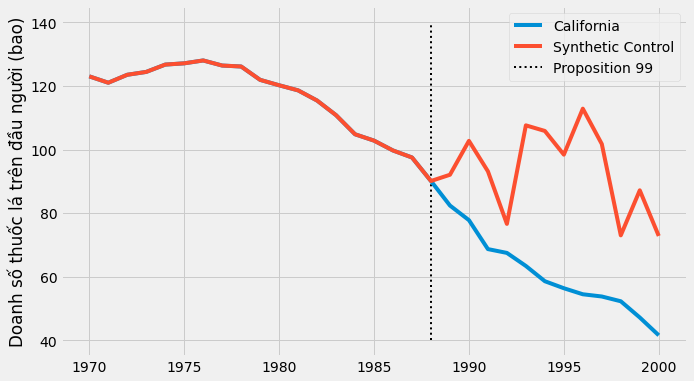

In [10]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Doanh số thuốc lá trên đầu người (bao)")
plt.legend();

Chờ chút… Có gì đó không ổn ở đây. Điều gì gây chú ý trong biểu đồ này? Đầu tiên, sau khi can thiệp, đối chứng tổng hợp có doanh số bán thuốc lá nhiều hơn California. Đây là một dấu hiệu cho thấy can thiệp đã thành công trong việc giảm nhu cầu thuốc lá. Thứ hai, hãy chú ý xem giai đoạn trước can thiệp được hồi quy hoàn hảo như thế nào. Đối chứng tổng hợp có thể khớp chính xác với bang California. Đây là một dấu hiệu cho thấy mô hình đối chứng tổng hợp có thể đang quá khớp với dữ liệu. Một dấu hiệu khác là có sự dao động rất lớn trong kết quả của đối chứng tổng hợp sau can thiệp. Ta có thể thấy đường kết quả không có một dáng vẻ mềm mại. Thay vào đó, nó dao động lên xuống và lại lên rồi xuống.

![img](./data/img/synth-control/out-of-sample.png)

Thử nghĩ xem tại sao điều này lại xảy ra, hãy nhớ rằng chúng ta có 38 tiểu bang trong tổ hợp đối chứng. Vì vậy, hồi quy tuyến tính có 38 tham số để cho tổ hợp đối chứng trước can thiệp khớp với nhóm can thiệp hết mức có thể. Đây là trường hợp mà ngay cả khi với T lớn, thì N cũng lớn, điều này mang lại quá nhiều dao động cho mô hình hồi quy tuyến tính. Nếu bạn đã quen với mô hình chính quy hoá, có thể sử dụng hồi quy Ridge hoặc Lasso để khắc phục. Tại đây, chúng ta sẽ xem xét phương pháp cổ điển hơn để tránh tình trạng quá khớp.

## Đừng Ngoại suy

Giả sử ta có dữ liệu như sau và được yêu cầu lập một đối chứng tổng hợp để tái tạo đối tượng được can thiệp bằng cách sử dụng bất kỳ tổ hợp tuyến tính nào của các đối tượngcá thể đối chứng.

|unit|sales|price|
|--|--|--|
|control 1|8|8|
|control 2|8|4|
|control 3|4|5|
|treated  |2|10|

Bởi vì có 3 đối tượng và chỉ có 2 đặc điểm để ghép cặp, nên có nhiều giải pháp chính xác cho bài toán này, nhưng một giải pháp hay là nhân đối chứng đầu tiên với 2.25, thứ hai với -2 và lấy tổng. Lưu ý phép nhân thứ hai tạo ra một đối tượng giả lập với doanh số là -16 và giá là -8. Phép nhân này đang ngoại suy đối tượng đối chứng 2 cho một vùng dữ liệu không có nhiều ý nghĩa, vì giá thành và doanh số âm gần như là bất khả thi. Phép nhân đầu tiên cũng là một phép ngoại suy, vì nó gán đối tượng đầu tiên cho doanh số và giá cả là 18. Những con số này cao hơn nhiều so với những gì ta có trong dữ liệu, do đó là phép ngoại suy.

Đây là những gì hồi quy đang thực hiện khi chúng ta yêu cầu tạo ra một đối chứng tổng hợp. Phép ngoại suy không sai về mặt kỹ thuật, nhưng nó lại nguy hiểm trong thực tế. Chúng ta đang đưa ra giả thiết rằng dữ liệu mà chúng ta chưa từng thấy biểu hiện giống với dữ liệu mà ta có.

Một cách an toàn hơn là hạn chế đối chứng tổng hợp sao cho nó chỉ thực hiện phép nội suy. Để làm được như vậy, chúng ta sẽ hạn chế để các trọng số là số dương và có tổng bằng một. Lúc này, đối chứng tổng hợp sẽ là một tổ hợp lồi của các đối tượng trong tổ hợp đối chứng. Khi thực hiện phép nội suy, chúng ta sẽ quy chiếu đối tượng được can thiệp theo bao lồi được xác định bởi đối tượng đối chứng, giống như trong hình dưới đây.

![img](data/img/synth-control/extrapolation.png)

Có 2 điều cần lưu ý. Đầu tiên, phép nội suy sẽ không thể tạo ra sự ghép cặp hoàn hảo cho đối tượng được can thiệp trong trường hợp này. Sở dĩ như vậy là vì đối tượng can thiệp là đối tượngcá thể có doanh số thấp nhất và giá cao nhất. Kết hợp lồi chỉ có thể tái lập chính xác các đặc điểm nằm giữa các đối tượng đối chứng. Một điều cần lưu ý nữa là nội suy rất thưa thớt. Chúng ta sẽ quy chiếu đối tượng được can thiệp trên bề mặt của bao lồi và bề mặt này được xác định bởi chỉ một vài đối tượng. Vì vậy, phép nội suy sẽ gán trọng số bằng 0 cho nhiều đối tượng.

Đây cũng chỉ là ý tưởng chung, bây giờ chúng ta sẽ đi chi tiết hơn một chút. Đối chứng tổng hợp được xác định bởi

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

bây giờ, ta sẽ sử dụng các trọng số \\(\pmb{W}=(w_2, ..., w_{J+1})\\) nhằm tối thiểu hoá

$
||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^{\frac{1}{2}}
$

dưới các ràng buộc \\(w_2, ..., w_{J+1}\\) có giá trị dương và tổng bằng một. Lưu ý rằng \\(v_h\\) phản ánh tầm quan trọng của mỗi biến khi tối thiểu hoá sự khác biệt giữa đối tượng được can thiệp và đối chứng tổng hợp. Các \\(v\\) khác nhau sẽ cho ra các trọng số tối ưu khác nhau. Một cách để chọn \\(V\\) là làm sao để mỗi biến có giá trị trung bình bằng 0 và phương sai bằng 1. Một cách phức tạp hơn là chọn \\(V\\) sao cho các biến dự đoán \\(Y\\) tốt hơn có tầm quan trọng cao hơn. Nhằm giữ cho code thật đơn giản, mỗi biến sẽ được gán tầm quan trọng như nhau.

Để thực hiện điều này, trước tiên, hãy xác định hàm mất mát ở trên.

In [11]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W: np.array, treated: np.array, controls: List[np.array], V:np.array) -> float:
    diff = treated - reduce(add, [i * w for i, w in zip(controls, W)])
    return np.sqrt(np.mean(diff**2)) # I'm using the mean instead of the sum, but it doesn't matter much

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

Vì chúng ta cho rằng thuộc tính có tầm quan trọng như nhau, ta không cần phải lo lắng về v.

Bây giờ, để có được trọng số tối ưu, chúng ta sẽ sử dụng phương pháp tối ưu hoá quy hoạch toàn phương của scipy. Chúng ta sẽ ràng buộc các trọng số có tổng bằng 1 với

```python 
lambda x: np.sum(x) - 1
```

Ngoài ra, chúng ta sẽ thiết lập giới hạn tối ưu hóa trong khoảng từ 0 đến 1.

In [12]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

Thực hiện xong bước này, hãy lấy các trọng số xác định đối chứng tổng hợp

In [13]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.0000000000007458


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

Như vậy, với trọng số này, chúng ta đang nhân các bang 1,2 và 3 với 0, bang 4 với 0,0852, v.v. Chúng ta thấy rằng các trọng số phân bổ thưa thớt, đúng như những gì ta đã dự đoán. Ngoài ra, tổng tất cả các trọng số bằng một và nằm trong khoảng từ 0 đến 1, thỏa mãn ràng buộc tổ hợp lồi.

Bây giờ, để có được đối chứng tổng hợp, chúng ta có thể nhân các trọng số đó với các bang chính xác theo cách ta đã làm trước đây với các trọng số hồi quy.

In [14]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

Nếu chúng ta lập biểu đồ kết quả của đối chứng tổng hợp tại đây, chúng ta sẽ có một đường mượt mà hơn nhiều. Cũng lưu ý rằng đối chứng tổng hợp không tái tạo chính xác đối tượng được can thiệp trong giai đoạn trước can thiệp. Đây là một dấu hiệu tốt, vì nó cho thấy rằng chúng ta không bị quá khớp.

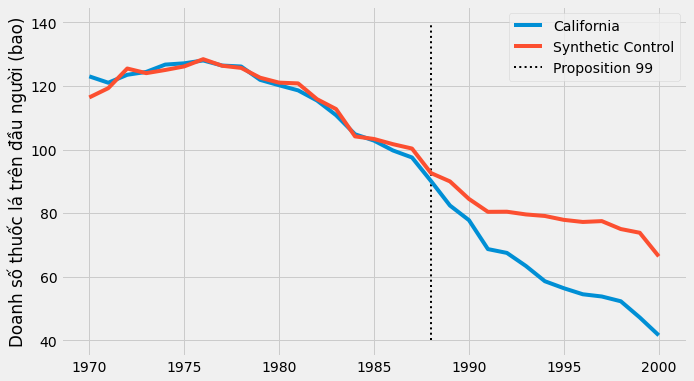

In [15]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Doanh số thuốc lá trên đầu người (bao)")
plt.legend();

Với biện pháp đối chứng tổng hợp trong tay, chúng ta có thể ước lượng tác động can thiệp bằng hiệu giữa kết quả được can thiệp và kết quả của đối chứng tổng hợp.

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

Trong trường hợp này, tác động ngày càng lớn qua thời gian.

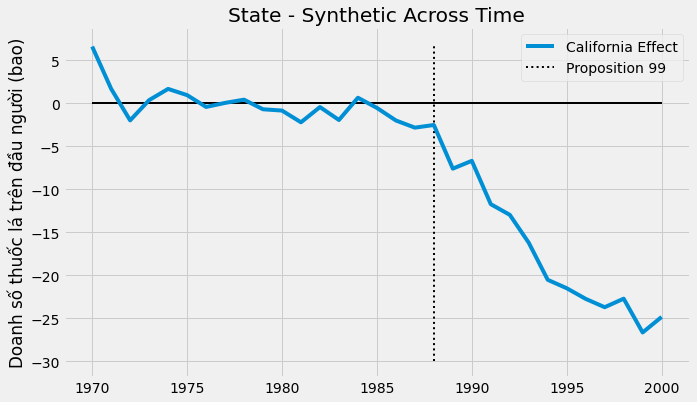

In [16]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Doanh số thuốc lá trên đầu người (bao)")
plt.legend();

Cho đến năm 2000, có vẻ như Dự luật 99 đã làm doanh số thuốc lá giảm 25%. Điều đó thật tuyệt, nhưng bạn cũng có thể tự vấn rằng: làm thế nào ta có thể biết được điều này mang ý nghĩa thống kê hay không?

## Suy Luận

Bởi vì chúng ta có kích thước mẫu rất nhỏ (39), ta sẽ phải tỉnh táo hơn khi muốn tìm hiểu xem liệu kết quả này thật sự có ý nghĩa về mặt thống kê hay chỉ do may mắn ngẫu nhiên. Tại đây, chúng ta sẽ ứng dụng ý tưởng về Kiểm Định Chính Xác của Fisher. Ý tưởng chủ đạo của nó rất đơn giản. Chúng ta hoán vị hoàn toàn các đối tượng được can thiệp và đối chứng. Vì chúng ta chỉ có một đối tượng được can thiệp, điều này có nghĩa là, đối với mỗi đối tượng, chúng ta giả định đó là đối tượng được can thiệp trong khi các đối tượngcá thể khác là đối chứng.

|iteration|1|2|...|39|
|----|-|-|-|-|
|1|treated|0|0|0|
|2|0|treated|0|0|
|...|0|0|0|0|0|0|
|39|0|0|0|treated|

Cuối cùng, chúng ta có một đối chứng tổng hợp và ước lượng tác động cho mỗi bang. Vì vậy, những gì phương pháp này làm là nó giả định can thiệp thực sự xảy ra cho một tiểu bang khác ngoài California, và xem tác động ước lượng cho can thiệp không xảy ra là gì. Sau đó, chúng ta xem liệu can thiệp tại Califórnia có lớn hơn đủ để so sánh với can thiệp giả lập khác hay không.

Để thực hiện điều này, tôi đã lập hàm số nhận dữ liệu đầu vào là một bang và ước lượng đối chứng tổng hợp cho bang đó. Hàm này trả về một khung dữ liệu với một cột biểu thị bang, một cột cho năm, một cột cho kết quả `cigsale` và kết quả tổng hợp cho bang đó.

In [17]:
def synthetic_control(state: int, pool: List[int], data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

Đây là kết quả khi ta áp dụng bước thứ nhất

In [18]:
control_pool = cigar["state"].unique()

synthetic_control(1, control_pool, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


Để có được kết quả cho tất cả các bang, chúng ta thực hiện song song việc tính toán trên 8 bộ vi xử lý. Nếu máy tính của bạn có nhiều hoặc ít lõi hơn, bạn có thể sử dụng một con số khác. Đoạn code này sẽ trả về một danh sách các khung dữ liệu như trên.

In [19]:
from joblib import Parallel, delayed

parallel_fn = delayed(partial(synthetic_control, pool=control_pool, data=cigar))

sinthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [20]:
sinthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


Với đối chứng tổng hợp cho tất cả các bang, chúng ta có thể ước lượng hiệu giữa kết quả tổng hợp và kết quả thực cho tất cả các bang. Đối với California, đây là tác động can thiệp. Đối với các bang khác, điều này giống như tác động giả dược, chúng ta ước lượng tác động can thiệp của đối chứng tổng hợp khi can thiệp không thực sự xảy ra. Nếu chúng ta lập biểu đồ cho tất cả tác động giả dược cùng với tác động can thiệp của California, chúng ta có như sau.

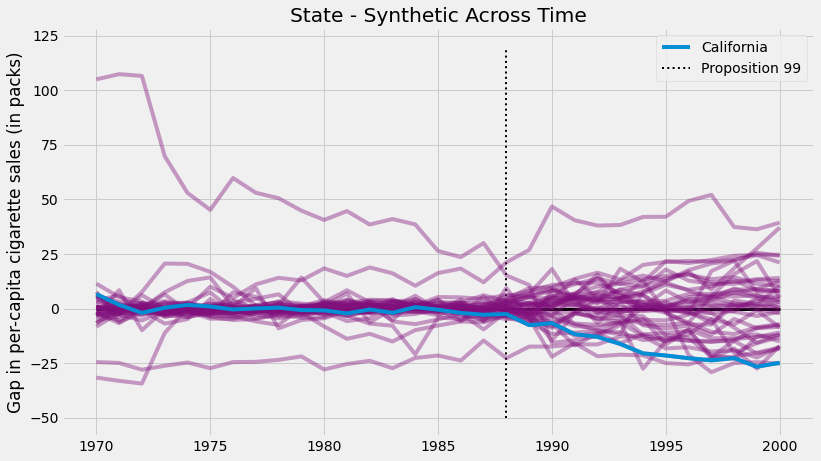

In [21]:
plt.figure(figsize=(12,7))
for state in sinthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

Có hai thông tin đáng chú ý. Đầu tiên, chúng ta có thể thấy rằng phương sai sau can thiệp cao hơn phương sai trước can thiệp. Điều này đúng như kỳ vọng, vì đối chứng tổng hợp được thiết kế để tối thiểu hoá sự khác biệt trong giai đoạn trước can thiệp. Một khía cạnh thú vị khác là có một số đối tượngcá thể không tương thích với mô hình ngay trong giai đoạn trước can thiệp. Điều này không ngoài dự đoán. Ví dụ, nếu một số bang có mức tiêu thụ thuốc lá rất cao thì sẽ không có tổ hợp lồi nào của các bang khác khớp với nó.

Vì những đối tượng đó tương thích quá kém, nên việc loại bỏ chúng ra khỏi phần phân tích là một ý kiến hay. Một cách để thực hiện một cách khách quan là đặt một ngưỡng cho lỗi trước can thiệp

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

và loại bỏ những đối tượng có lỗi cao. Nếu chúng ta tiếp tục làm như vậy và biểu diễn trên cùng một biểu đồ, đây là những gì chúng ta nhận được.

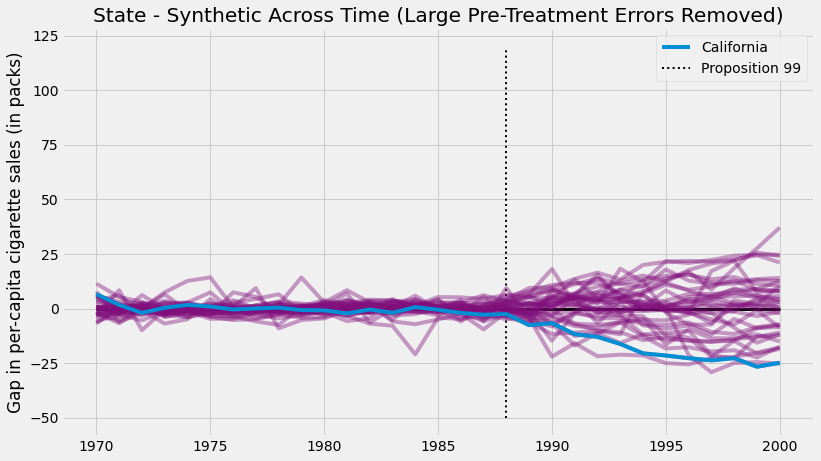

In [22]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in sinthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

Loại bỏ nhiễu, chúng ta có thể thấy tác động lớn đến mức nào tại bang California. Hình ảnh này cho chúng ta thấy rằng nếu chúng ta giả vờ việc can thiệp đã xảy ra ở bất kỳ tiểu bang nào khác, chúng ta gần như không bao giờ nhận được tác động quá lớn như những gì ở California.

Hình này chỉ là một dạng suy luận, nhưng chúng ta cũng có thể suy ra trị số p từ các kết quả này. Tất cả những gì chúng ta phải làm là xem thử có bao nhiêu lần những tác động mà chúng ta có được nhỏ hơn tác động tại California.

In [23]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in sinthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000 -24.83015975492409


array([  5.79715885,   0.89458997, -24.83015975,  -7.16628119,
       -10.92204857,  37.11640557, -15.0697172 ,  -0.49805133,
       -18.45795062,  21.13366443,  12.57782771,  -1.47547827,
        10.49627363, -11.67012374,   4.29850824,   8.04811405,
        14.02322418,   8.25002714,   0.32576358,  -8.40826855,
        -2.12402705,  -7.42865016,   2.9615753 ,  24.10478116,
         4.25211769, -17.75844564,   7.93334016,   2.81640126,
        12.6495596 , -17.47677512, -25.16040929, -12.26469131,
        24.69067366,  10.36299577,  -8.59880349])

Nếu chúng ta muốn kiểm định giả thuyết một phía rằng tác động tại California là dưới 0, chúng ta có thể ước lượng Trị số p vì tỷ lệ số lần mà tác động tại California lớn hơn tất cả các tác động ước lượng.

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\}
$

Hóa ra, tác động can thiệp tại California vào năm 2000 là -24,8, nghĩa là sự can thiệp đã làm giảm lượng thuốc lá tiêu thụ gần 25 bao. Trong số 34 tác động giả dược khác mà chúng ta đã ước lượng, chỉ có một tác động cao hơn tác động mà chúng ta có được tại California. Vì vậy, trị số p sẽ là 1/35.

In [24]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857

Cuối cùng, chúng ta có thể biểu diễn phân phối của các tác động để biết tác động tại California thực sự lớn đến mức nào.

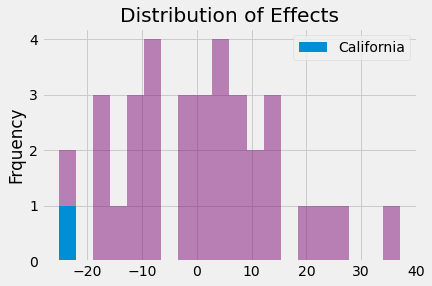

In [25]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();

## Ý tưởng chủ đạo

Chúng ta đã nắm được rằng nếu chỉ có dữ liệu tổng hợp về các thực thể như thành phố hoặc tiểu bang, thì phương pháp sai khác của biến thiên sẽ không cho phép ta thực hiện suy luận. Ngoài ra, nó có một số hạn chế khác, vì nó phải xác định một đối tượng được can thiệp và một đối tượngcá thể đối chứng duy nhất, và có thể đối tượng đối chứng này không phải là một đại diện tốt cho giả tưởng của đối tượng được can thiệp.

Để khắc phục điều đó, chúng ta đã học cách lập một đối chứng tổng hợp kết hợp nhiều đối tượng đối chứng để giả lập đối tượng được can thiệp. Với đối chứng tổng hợp, chúng ta có thể biết điều gì sẽ xảy ra với đối tượng được điều trị trong trường hợp không có can thiệp.

Cuối cùng, chúng ta đã có thể sử dụng Kiểm Định Chính Xác của Fisher để suy luận với đối chứng tổng hợp. Cụ thể, chúng ta đã giả định rằng các đối tượngcá thể không được can thiệp chính là đối tượng được xử lý và tính toán tác động của chúng. Chúng ta có tác động giả dược: những tác động mà chúng ta quan sát được thậm chí khi không có can thiệp. Sau đó, chúng ta thấy giá trị của tác động can thiệp thực sự lớn như thế nào so với tác động giả dược.

## Tài liệu tham khảo

Tôi muốn dành loạt bài viết này để vinh danh Joshua Angrist, Alberto Abadie and Christopher Walters vì khóa học Kinh tế lượng tuyệt cú mèo của họ. Phần lớn ý tưởng trong loạt bài này được lấy từ các bài giảng của họ được tổ chức bởi Hiệp hội Kinh tế Mĩ.  Theo dõi các bài giảng này là những gì tôi làm trong suốt năm 2020 khó nhằn.
* [Kinh tế lượng với dữ liệu chéo](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Luyện chưởng Kinh tế lượng Gần như Vô hại](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Tôi cũng muốn giới thiệu cuốn sách lý thú của Angrist. Chúng cho tôi thấy Kinh tế lượng, hoặc 'Lượng theo cách họ gọi không chỉ vô cùng hữu ích mà còn rất vui.

* [Kinh tế lượng Gần như Vô hại](https://www.mostlyharmlesseconometrics.com/)
* [Luyện chưởng 'Lượng](https://www.masteringmetrics.com/)

Tài liệu tham khảo cuối cùng của tôi là cuốn sách của Miguel Hernan and Jamie Robins. Nó là người bạn đồng hành tin cậy với tôi khi trả lời những câu hỏi nhân quả khó nhằn.

* [Sách Suy Luận Nhân Quả](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Cuối cùng, tôi muốn gửi lời tri ân đến Scott Cunningham và công trình tuyệt vời của anh ấy kết hợp Suy Luận Nhân Quả và Rap:

* [Suy Luận Nhân Quả: Chiếc Băng Cát Sét](https://www.scunning.com/mixtape.html)

# Bảng Thuật ngữ 
| Thuật ngữ | Tiếng Anh |
| --- | --- | 
|biến|variable| 
|biến giả|dummy, dummy variable| 
|biến giải thích|covariate| 
|biến kết quả|outcome variable| 
|bình quân gia quyền|weighted average| 
|code|code| 
|giả tưởng|counterfactual| 
|hàm mất mát|loss function| 
|hệ số chặn|intercept| 
|hồi quy|regression, regress| 
|hồi quy tuyến tính|linear regression| 
|khung dữ liệu|data frame| 
|kích thước mẫu|sample size| 
|kết quả tiềm năng|potential outcome| 
|kết quả tổng hợp|synthetic outcome| 
|mô hình sai khác của biến thiên|difference-in-difference estimator| 
|ngoại suy|extrapolation, extrapolate| 
|nhóm đối chứng|control group, untreated group| 
|nội suy|interpolation| 
|phân phối|distribution| 
|phương sai|variance| 
|quá khớp|overfitting| 
|sai khác của biến thiên|difference in difference| 
|sai số chuẩn|standard error| 
|tham số|parameter| 
|trị số p|p-value| 
|tác động can thiệp|treatment effect, treatment impact| 
|tác động giả dược|placebo effect| 
|tối ưu hoá quy hoạch toàn phương|quadratic programming optimisation| 
|tổ hợp đối chứng|donor pool| 
|được can thiệp|treated| 
|đối chứng tổng hợp|synthetic control| 
